Notebook created to display plots of useful summary information from MgII catalogs.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
import seaborn as sns

import desispec.io
import fitsio
from desispec.coaddition import coadd_cameras
from desimodel.footprint import radec2pix
from scipy.signal import medfilt

from IPython.display import clear_output

#import common functions
%run /global/u2/l/lucasnap/git/QSO_AB/QSO_AB_CmnFns.py

#Write main catalog and physically impossible catalog
redux = 'loa'
ndim = 5
Mgii_fp = '/global/cfs/cdirs/desi/users/lucasnap/Temp-Catalogs/MgII-Absorbers-{}-nocuts.fits'.format(redux)


plt.rcParams.update({'font.size': 20})

MgII_cat_units = ['',"deg","deg",'','','','','','','angstrom','angstrom','angstrom','angstrom','angstrom','angstrom','','1e-17 erg / (Angstrom cm2 s)','1e-17 erg / (Angstrom cm2 s)','angstrom','angstrom','','1e-17 erg / (Angstrom cm2 s)','1e-17 erg / (Angstrom cm2 s)','angstrom','angstrom','','1e-17 erg / (Angstrom cm2 s)','1e-17 erg / (Angstrom cm2 s)','angstrom','angstrom','','','']

In [4]:
MgII_cat = fitsio.read(Mgii_fp,'MGII_ABSORBERS')

print(len(MgII_cat))
print(len(np.unique(MgII_cat['TARGETID'])))

print(MgII_cat.dtype)

934331
480567
[('TARGETID', '>i8'), ('RA', '>f8'), ('DEC', '>f8'), ('SURVEY', '<U4'), ('ZWARN', '>i8'), ('TSNR2_QSO', '>f4'), ('TSNR2_LYA', '>f4'), ('TSNR2_LRG', '>f4'), ('Z_QSO', '>f8'), ('EW_2796', '>f8'), ('EW_2803', '>f8'), ('EW_2796_ERR_LOW', '>f8'), ('EW_2803_ERR_LOW', '>f8'), ('EW_2796_ERR_HIGH', '>f8'), ('EW_2803_ERR_HIGH', '>f8'), ('Z_MGII', '>f8'), ('AMP_2796', '>f8'), ('AMP_2803', '>f8'), ('STDDEV_2796', '>f8'), ('STDDEV_2803', '>f8'), ('Z_MGII_ERR_LOW', '>f8'), ('AMP_2796_ERR_LOW', '>f8'), ('AMP_2803_ERR_LOW', '>f8'), ('STDDEV_2796_ERR_LOW', '>f8'), ('STDDEV_2803_ERR_LOW', '>f8'), ('Z_MGII_ERR_HIGH', '>f8'), ('AMP_2796_ERR_HIGH', '>f8'), ('AMP_2803_ERR_HIGH', '>f8'), ('STDDEV_2796_ERR_HIGH', '>f8'), ('STDDEV_2803_ERR_HIGH', '>f8'), ('CONTINUUM_METHOD', '<U7'), ('LINE_SNR_MIN', '>f8'), ('LINE_SNR_MAX', '>f8')]


In [5]:
#open MgII abs summary cat
MgII_cat = fitsio.read(Mgii_fp,'MGII_ABSORBERS')

MgII_cat = purity_cuts(MgII_cat,PIA_cut=False)

zdop = (MgII_cat['Z_MGII']-MgII_cat['Z_QSO'])/(1+MgII_cat['Z_QSO'])

#seperate into physically possible and physically impossible systems
main_cat = MgII_cat[zdop < (5000/300000)]
main_cat_fp = Mgii_fp.replace("nocuts","pure")
print('{} physically possible catalog entries after purity cuts'.format(len(main_cat)))

PI_cat = MgII_cat[zdop > (5000/300000)]
PI_cat_fp = Mgii_fp.replace("nocuts","PI")
print('{} physically impossible catalog entries after purity cuts'.format(len(PI_cat)))

#write catalogs
if os.path.exists(main_cat_fp):
    print('Removing old physically possible catalog')
    os.remove(main_cat_fp)
fitsio.write(main_cat_fp,main_cat,extname='MGII_ABSORBERS',units=MgII_cat_units)
print('Physically possible catalog written to: {}'.format(main_cat_fp))
    
if os.path.exists(PI_cat_fp):
    print('Removing old physically impossible catalog')
    os.remove(PI_cat_fp)
fitsio.write(PI_cat_fp,PI_cat,extname='MGII_ABSORBERS',units=MgII_cat_units)
print('Physically impossible catalog written to: {}'.format(PI_cat_fp))

Result of Positive Amplitude Cuts: 163886 systems removed
Result of Elliptical Cuts: 223727 systems removed
Returning catalog with 546718 entries
545905 physically possible catalog entries after purity cuts
810 physically impossible catalog entries after purity cuts
Removing old physically possible catalog
Physically possible catalog written to: /global/cfs/cdirs/desi/users/lucasnap/Temp-Catalogs/MgII-Absorbers-loa-pure.fits
Removing old physically impossible catalog
Physically impossible catalog written to: /global/cfs/cdirs/desi/users/lucasnap/Temp-Catalogs/MgII-Absorbers-loa-PI.fits


Removing 6285 physically impossible absorption systems
Result of Positive Amplitude Cuts: 161253 systems removed
Result of Elliptical Cuts: 220884 systems removed
Returning catalog with 545905 entries


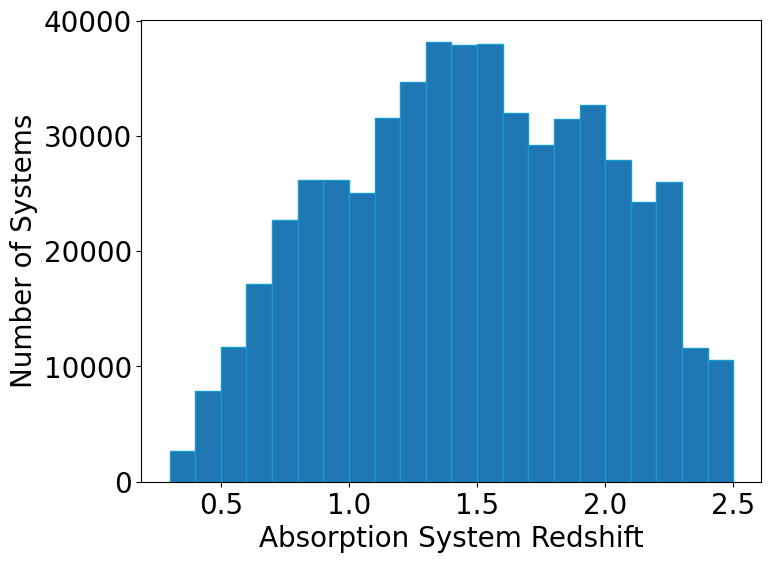

In [5]:
MgII_cat = fitsio.read(Mgii_fp,'MGII_ABSORBERS')

MgII_cat = purity_cuts(MgII_cat)

plt.figure(figsize=(8,6))
plt.hist(MgII_cat['Z_MGII'], bins=np.arange(0.3,2.51,0.1), edgecolor='#169acf')
plt.xlabel('Absorption System Redshift')
plt.ylabel('Number of Systems')
plt.show()

2456178 total QSOs
Removing 6285 physically impossible absorption systems
Result of Positive Amplitude Cuts: 161253 systems removed
Result of Elliptical Cuts: 220884 systems removed
Returning catalog with 545905 entries
Total number of QSO spectra searched: 2456178
Total number of MgII absorption systems detected: 545905
Total number of QSO spectra with MgII absorbers: 394561
Percentage of QSO spectra with MgII absorbers: 16.064023047189576%
Expected number of MgII absorbers per QSO spectra: 0.22225791453225296


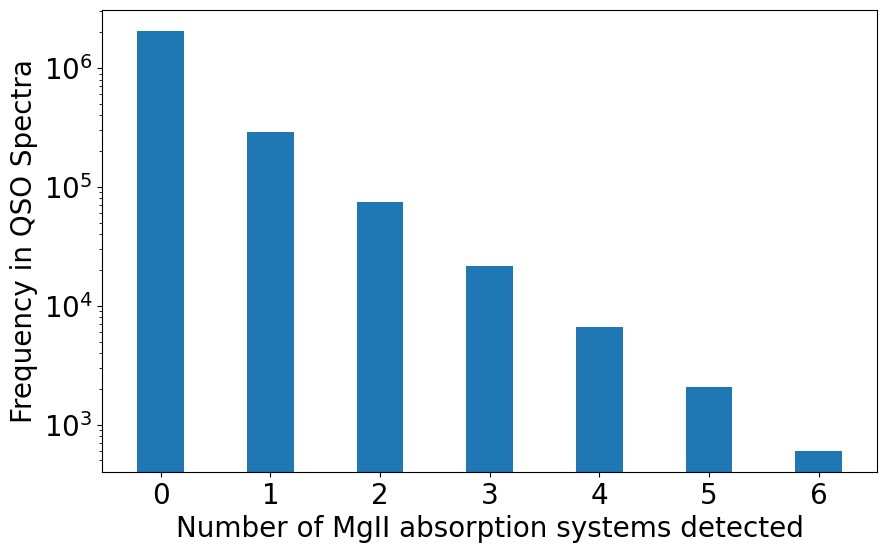

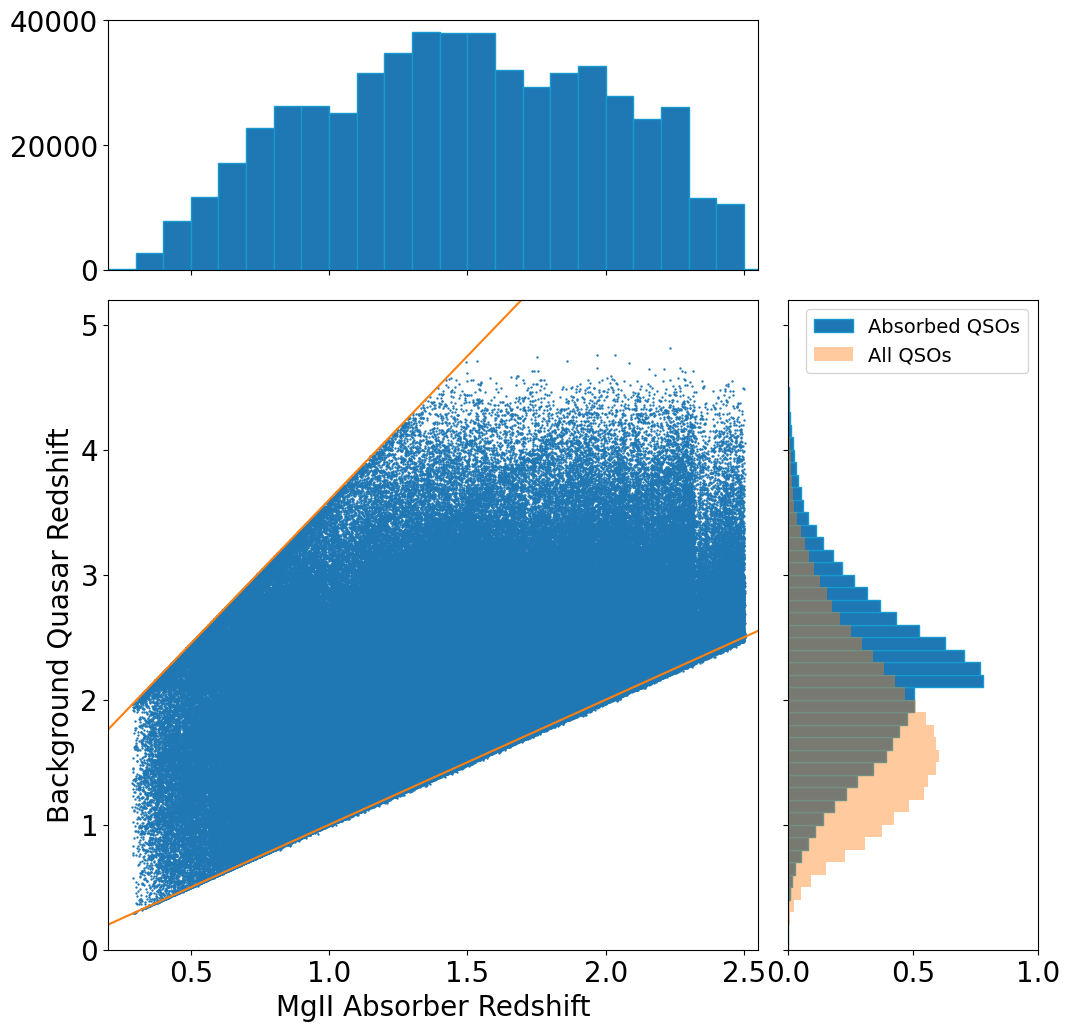

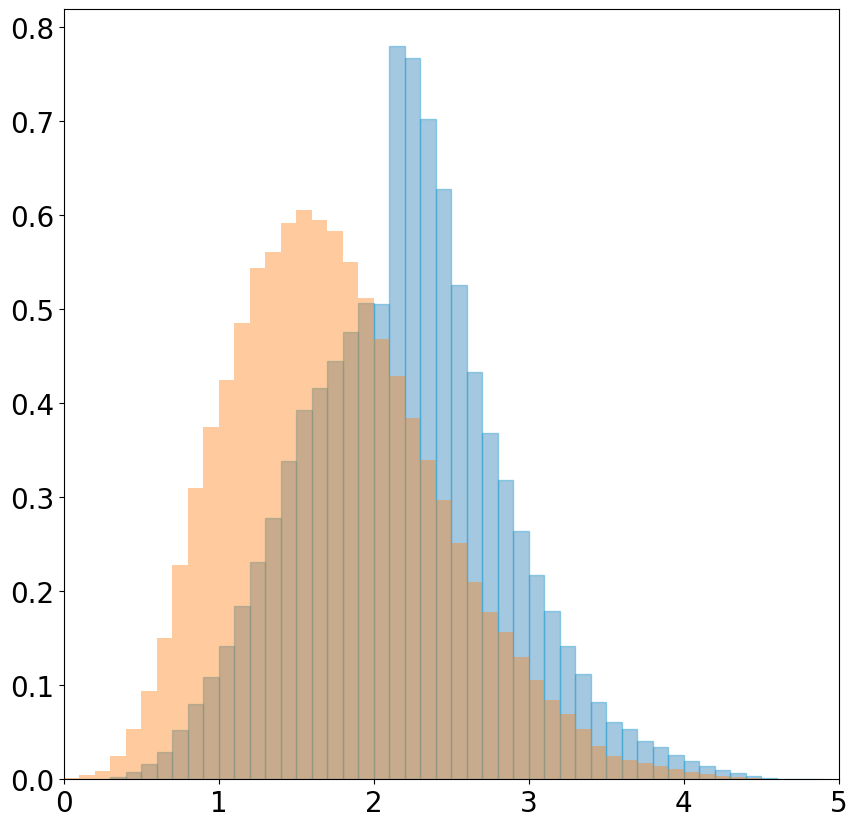

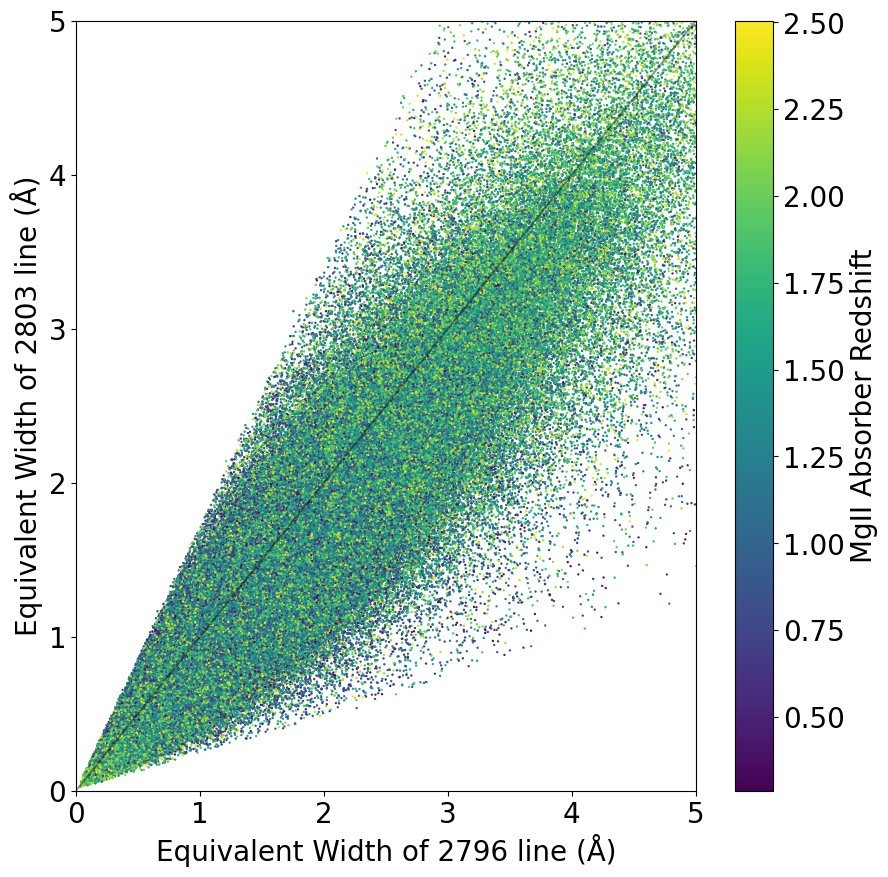

In [ ]:
reduction_base_dir='/global/cfs/cdirs/desi/spectro/redux/{}/'.format(redux)

#getting all qso redshifts
if redux == 'fuji' or redux == 'guadalupe':
    QSOcat_fp = '/global/cfs/cdirs/desi/users/edmondc/QSO_catalog/{}/QSO_cat_{}_healpix_only_qso_targets.fits'.format(redux,redux)
elif redux == 'iron':
    QSOcat_fp = '/global/cfs/cdirs/desi/survey/catalogs/Y1/QSO/{}/QSO_cat_{}_main_dark_healpix_only_qso_targets_vtest.fits'.format(redux,redux)
elif redux == 'loa':
    QSOcat_fp = '/global/cfs/cdirs/desi/survey/catalogs/DA2/QSO/loa/QSO_cat_loa_main_dark_healpix_only_qso_targets_v2.fits'
#QSOcat_fp='/global/cfs/cdirs/desi/users/edmondc/QSO_catalog/{}/QSO_cat_{}_healpix_for_lyalpha.fits'.format(redux,redux)
#QSOcat_fp='/global/cfs/cdirs/desi/users/edmondc/QSO_catalog/{}/QSO_cat_fuji_healpix.fits'.format(redux)

QSOcat=fitsio.read(QSOcat_fp,'QSO_CAT')
QSOcat = QSOcat[QSOcat['PROGRAM'] == 'dark']
print('{} total QSOs'.format(len(QSOcat)))

QSO_cat_allz=QSOcat['Z']


plt.rcParams.update({'font.size': 20})

#open MgII abs summary cat
MgII_cat = fitsio.read(Mgii_fp,'MGII_ABSORBERS')

MgII_cat = purity_cuts(MgII_cat)

MgII_abs_unique_targetid, MgII_abs_counts = np.unique(MgII_cat['TARGETID'], return_counts=True)

#
print('Total number of QSO spectra searched: {}'.format(len(QSO_cat_allz)))
print('Total number of MgII absorption systems detected: {}'.format(len(MgII_cat)))

print('Total number of QSO spectra with MgII absorbers: {}'.format(len(MgII_abs_unique_targetid)))
print('Percentage of QSO spectra with MgII absorbers: {}%'.format(100*len(MgII_abs_unique_targetid)/len(QSO_cat_allz)))
print('Expected number of MgII absorbers per QSO spectra: {}'.format(len(MgII_cat)/len(QSO_cat_allz)))

plt.figure(figsize=(10,6))
plt.hist(MgII_abs_counts,rwidth=0.85,log=True,bins=np.arange(0,7,0.5),align='left')
plt.hist(x=np.zeros(len(QSO_cat_allz)-len(MgII_abs_unique_targetid)),rwidth=0.85,color='C00',bins=np.arange(0,7,0.5),align='left')
plt.xlabel('Number of MgII absorption systems detected')
plt.ylabel('Frequency in QSO Spectra')
plt.show()

#all from https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
#spacing /location stuff of plot elements
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.03

right_plot_width=1.0

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.25]
rect_histy = [left + width + spacing, bottom, 0.25, height]

fig = plt.figure(figsize=(10,10))

#add axes
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)

ax_histy = fig.add_axes(rect_histy, sharey=ax)

#disable overlapping axis labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

#main plot
ax.scatter(MgII_cat['Z_MGII'],MgII_cat['Z_QSO'],s=0.5)
x=np.arange(0,2.6,0.01)
ax.plot(x,x,c='C01')
ax.plot(x,(x+1)*first_line_wave/1216-1,c='C01')

ax.set_ylabel('Background Quasar Redshift')
ax.set_xlabel('MgII Absorber Redshift')
ax.set_ylim(0,5.2)
ax.set_xlim(0.2,2.55)

#Histogram setup
binwidth = 0.1
xymax = max(np.max(np.abs(MgII_cat['Z_MGII'])), np.max(np.abs(MgII_cat['Z_QSO'])))
lim = (int(xymax/binwidth) + 1) * binwidth
bins = np.arange(-lim, lim + binwidth, binwidth)

#Adding histograms
ax_histx.hist(MgII_cat['Z_MGII'], bins=bins, edgecolor='#169acf')
ax_histy.hist(MgII_cat['Z_QSO'], bins=bins, orientation='horizontal', edgecolor='#169acf',density=True,label='Absorbed QSOs')
ax_histy.hist(QSO_cat_allz,alpha=0.4,density=True,bins=bins,label='All QSOs',orientation='horizontal')
ax_histy.legend(fontsize=14)

#replacing histogram labels to avoid overlapping #s
#ax_histx.set_yticks([0,250,500])
#ax_histx.set_yticklabels(['','250','500'])

ax_histy.set_xticks([0,0.5,1])
#ax_histy.set_xticklabels(['','250','500'])

plt.show()

#plt5_data = np.array([MgII_cat['Z_MGII'],MgII_cat['Z_QSO']])
#np.savetxt('plt5_data.csv',plt5_data,delimiter=',')

plt.figure(figsize=(10,10))
plt.hist(MgII_cat['Z_QSO'],bins=bins,edgecolor='#169acf',alpha=0.4,density=True)
plt.hist(QSO_cat_allz,alpha=0.4,density=True,bins=bins)

plt.xlim(0,5)
plt.show()

#plt.figure(figsize=(10,10))
#plt.scatter(MgII_cat['TSNR2'],MgII_cat['EW_2796'],s=0.5)
#plt.xlabel('FLUX_R')
#plt.ylabel('EW_2796')
#plt.xlim(-1,100)
#plt.ylim(-1,20)
#plt.show()

#plt.figure(figsize=(10,10))
#plt.scatter(MgII_cat['AMP_2796']/MgII_cat['AMP_2803'],MgII_cat['STDDEV_2796']/MgII_cat['STDDEV_2803'],s=0.5)
#plt.xlabel('Line Amplitude Ratio')
#plt.ylabel('Line Width Ratio')
#plt.xlim(-1,4)
#plt.ylim(0,4)
#plt.show()


plt.figure(figsize=(10,10))

x=np.arange(0,8,0.01)
plt.plot(x,x,c='black',alpha=0.4)

plt.scatter(MgII_cat['EW_2796'],MgII_cat['EW_2803'],s=0.5,c=MgII_cat['Z_MGII'])
plt.colorbar(label='MgII Absorber Redshift')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Equivalent Width of 2796 line (Å)')
plt.ylabel('Equivalent Width of 2803 line (Å)')
plt.show()

#plt6_data = np.array([MgII_cat['EW_2796'],MgII_cat['EW_2803']])
#np.savetxt('plt6_data.csv',plt6_data,delimiter=',')

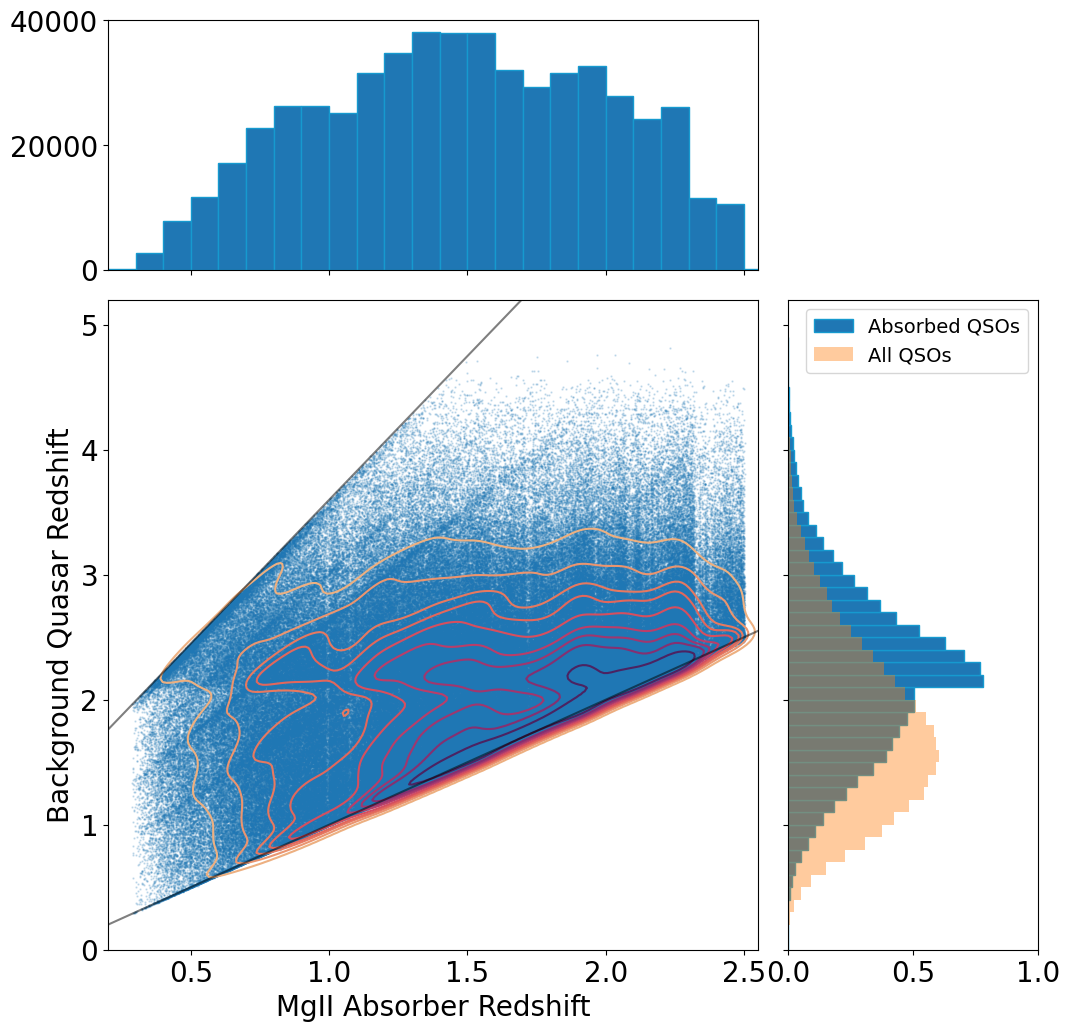

In [7]:
#all from https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
#spacing /location stuff of plot elements
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.03

right_plot_width=1.0

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.25]
rect_histy = [left + width + spacing, bottom, 0.25, height]

fig = plt.figure(figsize=(10,10))
#add axes
ax = fig.add_axes(rect_scatter)
sns.kdeplot(x=MgII_cat['Z_MGII'].tolist(),y=MgII_cat['Z_QSO'].tolist(),levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],cmap="flare")

ax_histx = fig.add_axes(rect_histx, sharex=ax)

ax_histy = fig.add_axes(rect_histy, sharey=ax)

#disable overlapping axis labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

#main plot
ax.scatter(MgII_cat['Z_MGII'],MgII_cat['Z_QSO'],s=0.5,alpha=0.2)
x=np.arange(0,2.6,0.01)
ax.plot(x,x,c='k',alpha=0.5)
ax.plot(x,(x+1)*first_line_wave/1216-1,c='k',alpha=0.5)

ax.set_ylabel('Background Quasar Redshift')
ax.set_xlabel('MgII Absorber Redshift')
ax.set_ylim(0,5.2)
ax.set_xlim(0.2,2.55)

#Histogram setup
binwidth = 0.1
xymax = max(np.max(np.abs(MgII_cat['Z_MGII'])), np.max(np.abs(MgII_cat['Z_QSO'])))
lim = (int(xymax/binwidth) + 1) * binwidth
bins = np.arange(-lim, lim + binwidth, binwidth)

#Adding histograms
ax_histx.hist(MgII_cat['Z_MGII'], bins=bins, edgecolor='#169acf')
ax_histy.hist(MgII_cat['Z_QSO'], bins=bins, orientation='horizontal', edgecolor='#169acf',density=True,label='Absorbed QSOs')
ax_histy.hist(QSO_cat_allz,alpha=0.4,density=True,bins=bins,label='All QSOs',orientation='horizontal')
ax_histy.legend(fontsize=14)

#replacing histogram labels to avoid overlapping #s
#ax_histx.set_yticks([0,250,500])
#ax_histx.set_yticklabels(['','250','500'])

ax_histy.set_xticks([0,0.5,1])
#ax_histy.set_xticklabels(['','250','500'])

plt.show()

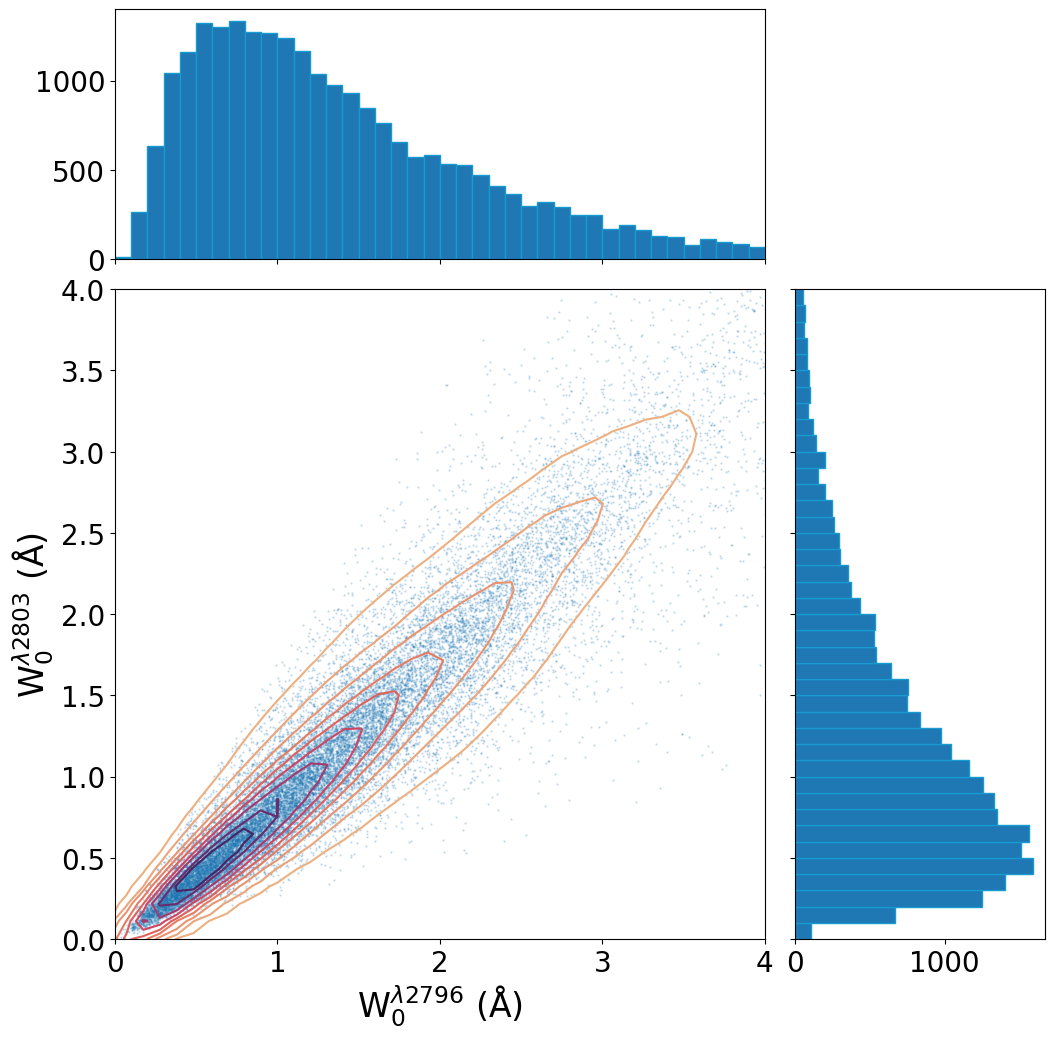

In [6]:
#figuring out contour plots
import seaborn as sns

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.03

right_plot_width=1.0

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.25]
rect_histy = [left + width + spacing, bottom, 0.25, height]

fig = plt.figure(figsize=(10,10))
#add axes
ax = fig.add_axes(rect_scatter)
sns.kdeplot(x = MgII_cat['EW_2796'].tolist(),y = MgII_cat['EW_2803'].tolist(),levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],cmap="flare")


ax_histx = fig.add_axes(rect_histx, sharex=ax)

ax_histy = fig.add_axes(rect_histy, sharey=ax)

#disable overlapping axis labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

#main plot
ax.scatter(MgII_cat['EW_2796'],MgII_cat['EW_2803'],s=0.5,alpha=0.2)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_xlabel('W$_0^{\lambda 2796}$ (Å)',fontsize=24)
ax.set_ylabel('W$_0^{\lambda 2803}$ (Å)',fontsize=24)

#Histogram setup
binwidth = 0.1
xymax = max(np.max(np.abs(MgII_cat['EW_2796'])), np.max(np.abs(MgII_cat['EW_2803'])))
lim = (int(xymax/binwidth) + 1) * binwidth
bins = np.arange(-lim, lim + binwidth, binwidth)

#Adding histograms
ax_histx.hist(MgII_cat['EW_2796'], bins=bins, edgecolor='#169acf')
ax_histy.hist(MgII_cat['EW_2803'], bins=bins, orientation='horizontal', edgecolor='#169acf')
#ax_histy.legend(fontsize=14)

#replacing histogram labels to avoid overlapping #s
#ax_histx.set_yticks([0,250,500])
#ax_histx.set_yticklabels(['','250','500'])

#ax_histy.set_xticks([0,0.5,1])

plt.show()

1.1892383851181416


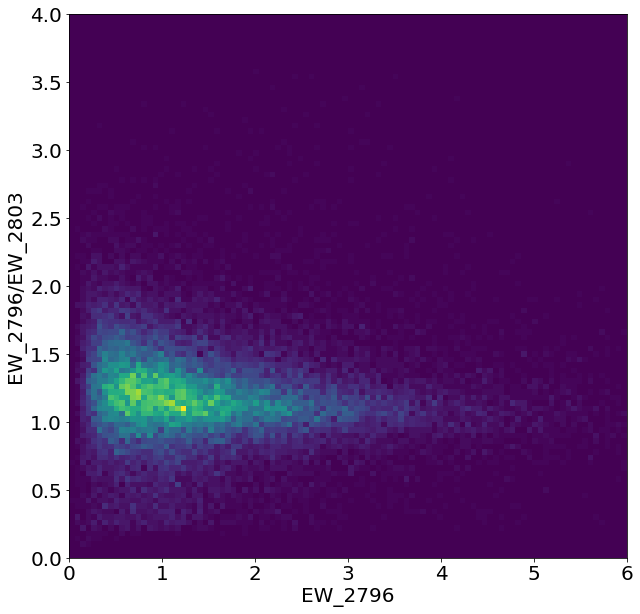

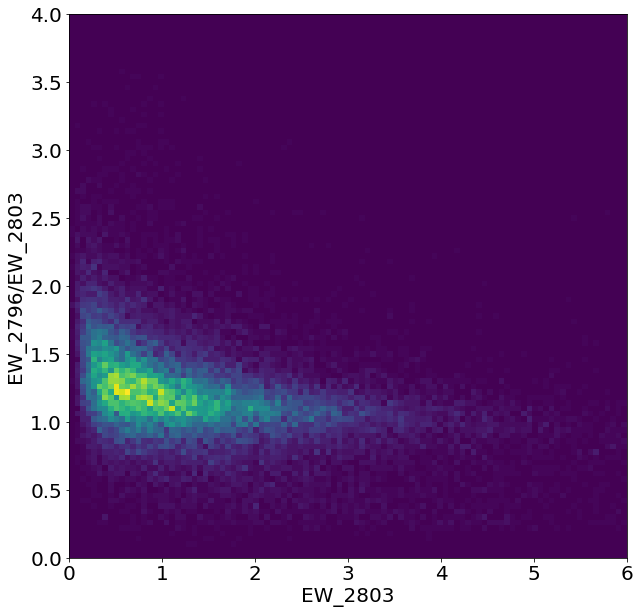

In [6]:
redux='fuji'
reduction_base_dir='/global/cfs/cdirs/desi/spectro/redux/{}/'.format(redux)

Mgii_fp='/global/cfs/cdirs/desi/users/lucasnap/MgII-Absorber-Catalog-{}/v1.0/MgII-Absorbers-fuji.fits'.format(redux)

#open MgII abs summary cat
MgII_cat=fitsio.read(Mgii_fp,'MGII_ABSORBERS')

print(np.mean(MgII_cat['EW_2796']/MgII_cat['EW_2803']))


plt.figure(figsize=(10,10))
plt.hist2d(MgII_cat['EW_2796'],MgII_cat['EW_2796']/MgII_cat['EW_2803'],range=[[0,6],[0,4]],bins=100)
plt.xlabel('EW_2796')
plt.ylabel('EW_2796/EW_2803')
plt.show()

plt.figure(figsize=(10,10))
plt.hist2d(MgII_cat['EW_2803'],MgII_cat['EW_2796']/MgII_cat['EW_2803'],range=[[0,6],[0,4]],bins=100)
plt.xlabel('EW_2803')
plt.ylabel('EW_2796/EW_2803')
plt.show()

INFO:spectra.py:391:read_spectra: iotime 2.932 sec to read coadd-sv3-dark-26278.fits at 2024-11-04T12:44:52.811282


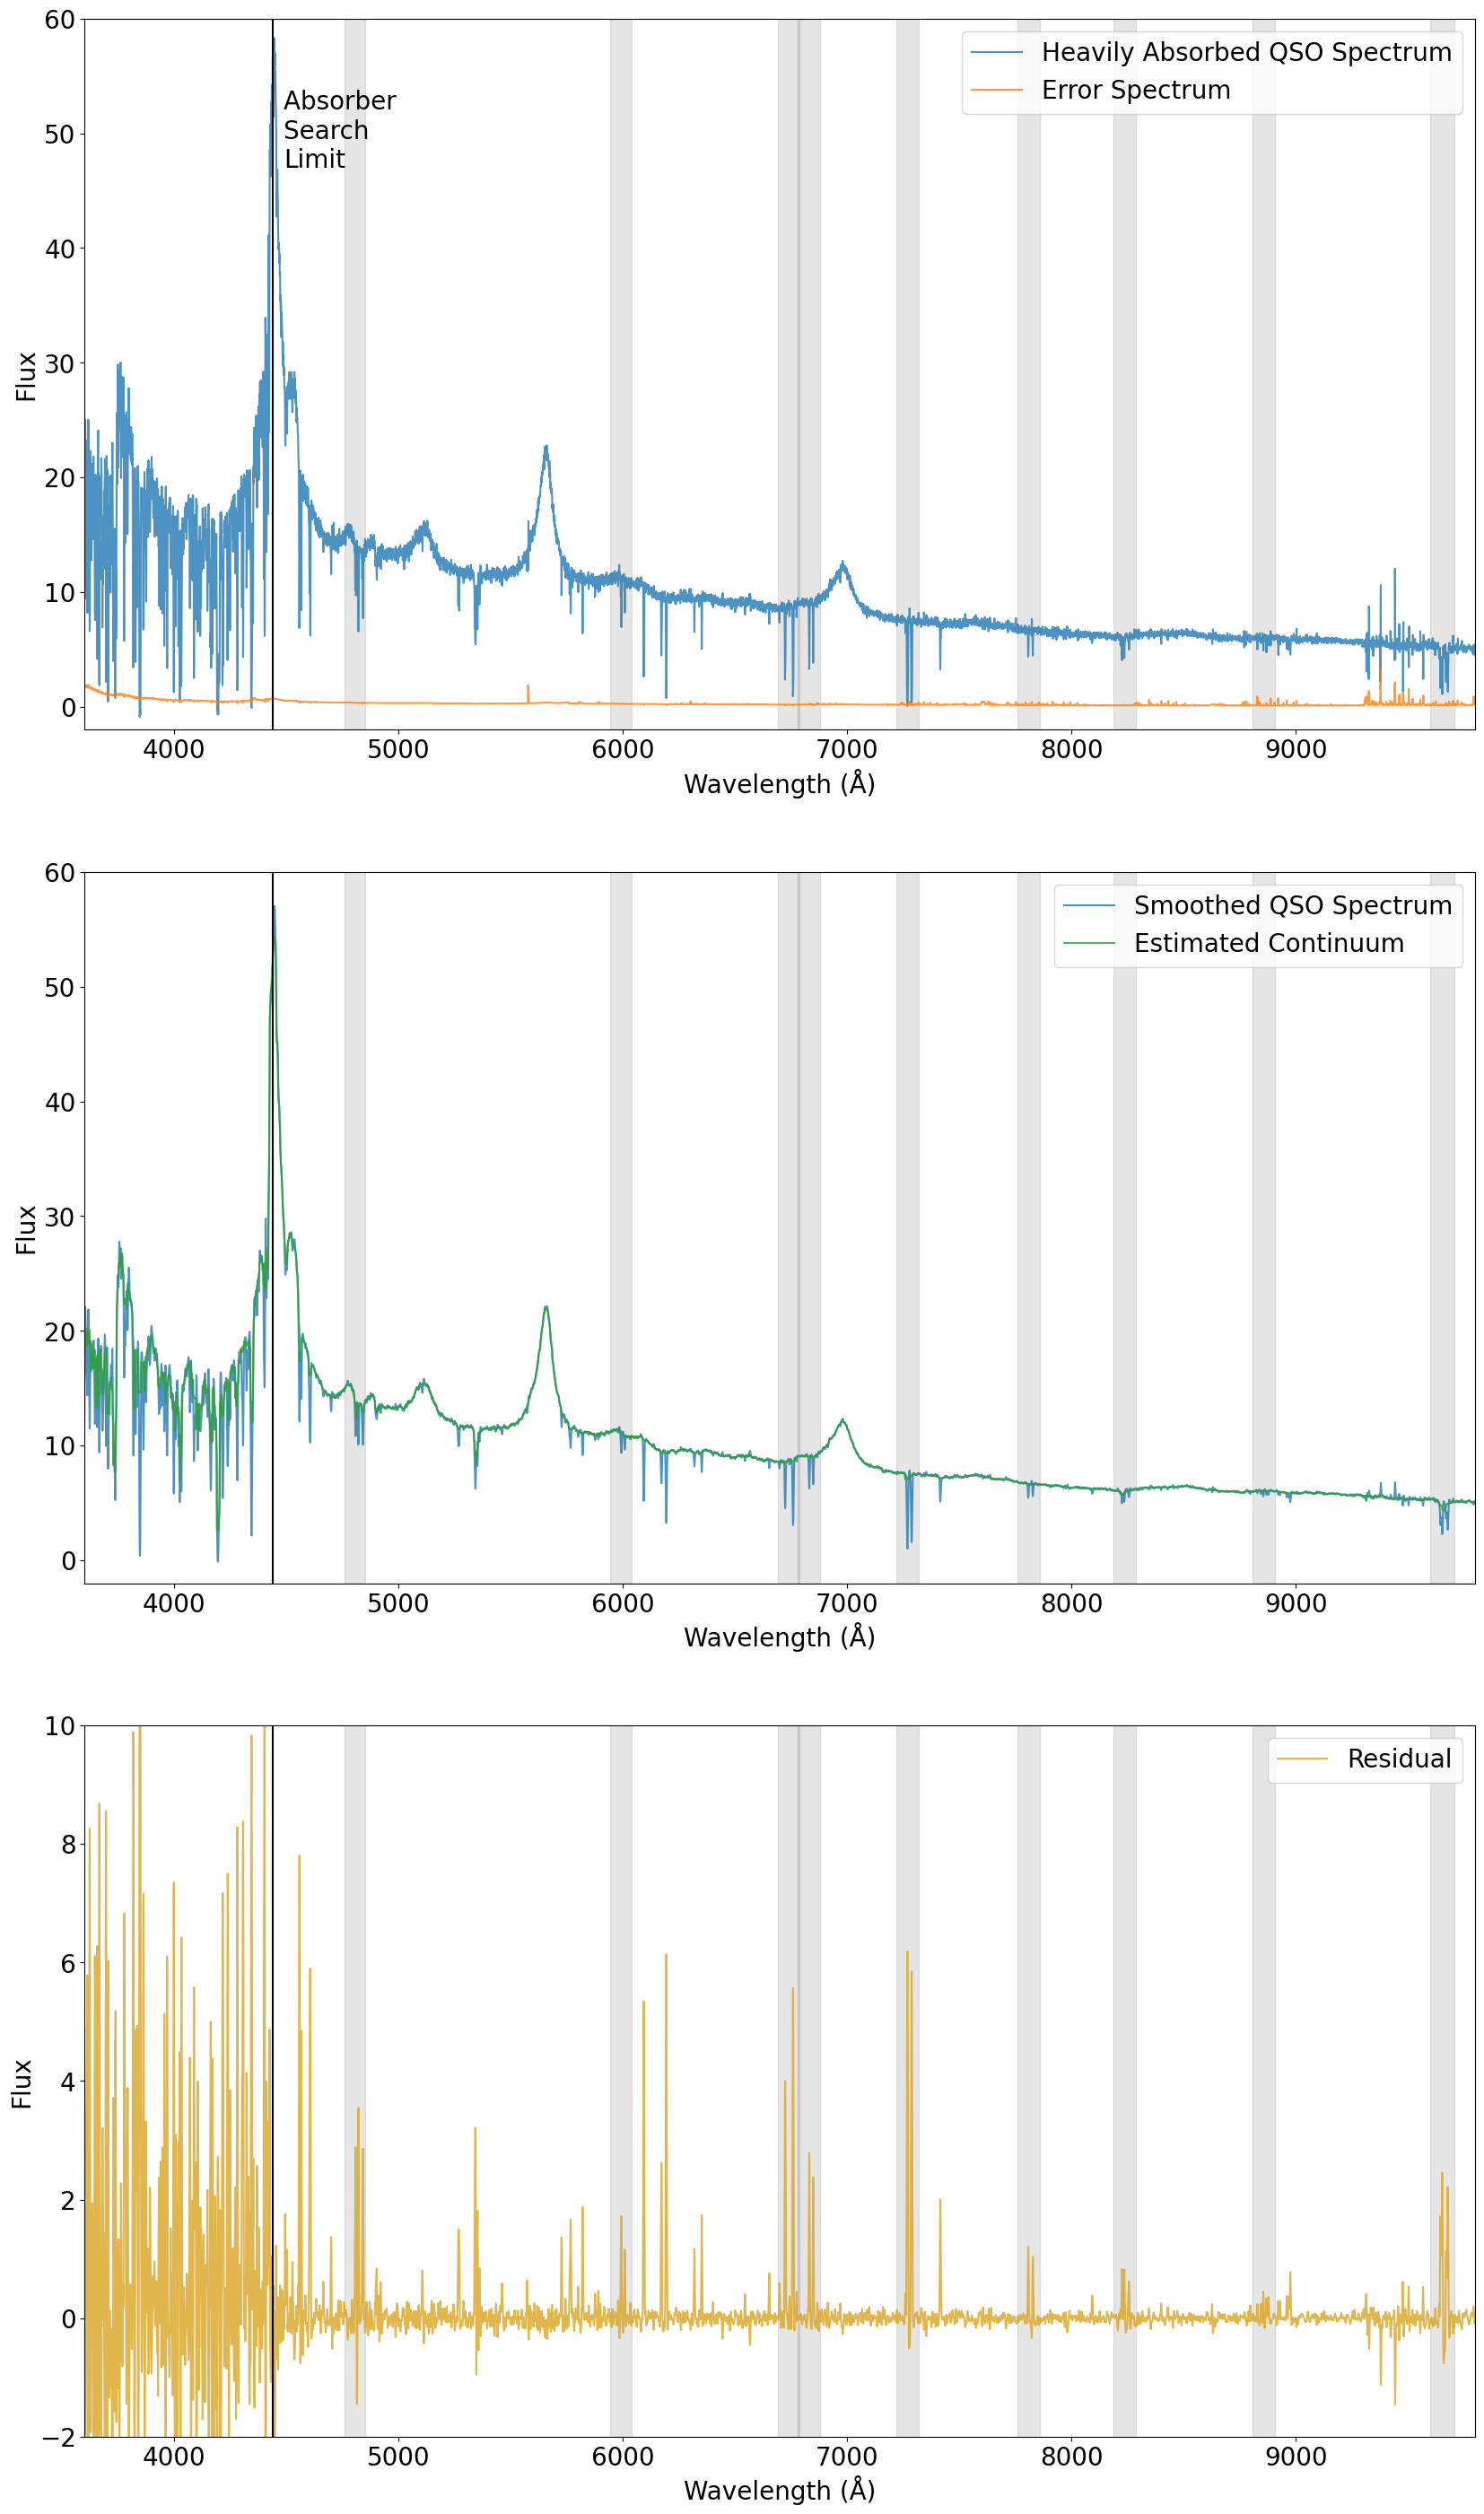

In [7]:
#old 39627776285740167

plt.rcParams.update({'font.size': 20})

#Cell to creat the 6abs plot in paper, don't delete again you dummy
kernel_smooth = 2
kernel = Gaussian1DKernel(stddev = kernel_smooth)

med_filt_size_tight = 19
med_filt_size_wide = 39

#TID = 39627776285740167
MgII_cat_inds = np.where(MgII_cat['TARGETID'] == 39627787799106526)[0]

fi = MgII_cat_inds[0]

hp = radec2pix(64,MgII_cat['RA'][fi],MgII_cat['DEC'][fi])

z_abs = MgII_cat['Z_MGII'][MgII_cat_inds]

spec = get_spec_healpix(MgII_cat['TARGETID'][fi],hp,MgII_cat['SURVEY'][fi],'fuji')

x_spc = spec.wave['brz']
y_flx = spec.flux['brz'][0]
y_err = 1/np.sqrt(spec.ivar['brz'][0])

#apply gaussian smoothing kernel
smooth_yflx = convolve(y_flx,kernel)

c_tight = medfilt(y_flx,med_filt_size_tight)
c_wide = medfilt(y_flx,med_filt_size_wide)
#length of filter scale for normalizing
f_scale = len(c_tight)
#weight tight filter higher at low z and wide filter higher at high z
cont_est = c_tight*(1-np.arange(f_scale )/f_scale) + c_wide*(np.arange(f_scale )/f_scale)

f, (ax0, ax1, ax2) = plt.subplots(3,1,figsize=(20,35))

ax0.plot(x_spc,y_flx,label = 'Heavily Absorbed QSO Spectrum',alpha=0.8)
ax0.plot(x_spc,y_err,label = 'Error Spectrum',alpha=0.8)
ax0.axvline(1216*(1+MgII_cat['Z_QSO'][fi]),c='k')
ax0.text(50+1216*(1+MgII_cat['Z_QSO'][fi]),y=47,s='Absorber \nSearch \nLimit',c='k')
for z in z_abs:
    ax0.fill_betweenx([-100,100], first_line_wave*(1+float(z))-50, x2=second_line_wave*(1+float(z))+30, alpha=0.2, color='gray')

ax0.set_xlim(3600,9800)
ax0.set_ylim(-2,60)
ax0.set_xlabel('Wavelength (Å)')
ax0.set_ylabel('Flux')
ax0.legend()

ax1.plot(x_spc,smooth_yflx,label = 'Smoothed QSO Spectrum',alpha=0.8)
ax1.plot(x_spc,cont_est, label = 'Estimated Continuum',c='C02',alpha=0.8)
ax1.axvline(1216*(1+MgII_cat['Z_QSO'][fi]),c='k')
for z in z_abs:
    ax1.fill_betweenx([-100,100], first_line_wave*(1+float(z))-50, x2=second_line_wave*(1+float(z))+30, alpha=0.2, color='gray')

ax1.set_xlim(3600,9800)
ax1.set_ylim(-2,60)
ax1.set_xlabel('Wavelength (Å)')
ax1.set_ylabel('Flux')
ax1.legend()

ax2.plot(x_spc,cont_est-smooth_yflx, label = 'Residual',c='goldenrod',alpha=0.8)
ax2.axvline(1216*(1+MgII_cat['Z_QSO'][fi]),c='k')
for z in z_abs:
    ax2.fill_betweenx([-100,100], first_line_wave*(1+float(z))-50, x2=second_line_wave*(1+float(z))+30, alpha=0.2, color='gray')

ax2.set_xlim(3600,9800)
ax2.set_ylim(-2,10)
ax2.set_xlabel('Wavelength (Å)')
ax2.set_ylabel('Flux')
ax2.legend()

plt.show()

#plt_data = np.array([x_spc,y_flx,y_err,smooth_yflx,cont_est,cont_est-smooth_yflx])
#np.savetxt('plt_data.csv',plt_data,delimiter=',')